In [1]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.automl.base import AutoML

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from lightautoml.addons.interpretation import SSWARM

from clearml import Dataset

import pandas as pd
import os
import shap
import numpy as np
import lightgbm as lgb

## Data

In [19]:
X, y = shap.datasets.california()
X_train, X_test, y_train, y_test = train_test_split(X, y.astype(int), stratify=y.astype(int), random_state=77)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=77)

df_train = X_train.assign(target=y_train)
df_test = X_test.assign(target=y_test)#.sample(1000, random_state=77)
X_test = df_test.drop(columns="target")
y_test = df_test["target"]
df_val = X_val.assign(target=y_val)

## Model

In [3]:
boost_params = {
"task": "train",
"learning_rate": 0.05,
"num_leaves": 128,
"feature_fraction": 0.7,
"bagging_fraction": 0.7,
"bagging_freq": 1,
"max_depth": -1,
"verbosity": -1,
"reg_alpha": 1,
"reg_lambda": 0.0,
"min_split_gain": 0.0,
"zero_as_missing": False,
"num_threads": 4,
"max_bin": 255,
"min_data_in_bin": 3,
"num_trees": 3000,
"early_stopping_rounds": 100,
"random_state": 42,
# "metric" : "binary_logloss",
"objective": "regression"
}

In [4]:
task = Task('reg', metric="mse")
reader = PandasToPandasReader(task, random_state=77, advanced_roles=False)
model1 = BoostLGBM(boost_params, freeze_defaults=True)
pipeline_lvl1 = MLPipeline([model1])
automl = AutoML(reader=reader, levels=[[pipeline_lvl1]], skip_conn=False)

oof_pred = automl.fit_predict(df_train, valid_data=df_val, roles={'target': "target"}, verbose=4)

[19:56:01] Train data shape: (11610, 9)

[19:56:01] Layer 1 train process start. Time left 9999999999.97 secs
[19:56:01] Training until validation scores don't improve for 100 rounds
[19:56:02] [100]	valid's l2: 0.320547
[19:56:02] [200]	valid's l2: 0.31669
[19:56:02] Early stopping, best iteration is:
[144]	valid's l2: 0.316286
[19:56:03] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[19:56:03] Time left 9999999998.48 secs

[19:56:03] Layer 1 training completed.



In [20]:
d_train = lgb.Dataset(X_train, label=y_train)
d_val = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params=boost_params, train_set=d_train, valid_sets=[d_val])
explainer_default = shap.TreeExplainer(model)
shap_values_tree = explainer_default.shap_values(X_test)

Found `num_trees` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[1]	valid_0's l2: 1.497
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 1.41088
[3]	valid_0's l2: 1.33312
[4]	valid_0's l2: 1.25135
[5]	valid_0's l2: 1.17793
[6]	valid_0's l2: 1.11077
[7]	valid_0's l2: 1.04685
[8]	valid_0's l2: 0.993355
[9]	valid_0's l2: 0.943868
[10]	valid_0's l2: 0.893782
[11]	valid_0's l2: 0.847615
[12]	valid_0's l2: 0.805544
[13]	valid_0's l2: 0.769789
[14]	valid_0's l2: 0.737465
[15]	valid_0's l2: 0.703188
[16]	valid_0's l2: 0.675243
[17]	valid_0's l2: 0.647346
[18]	valid_0's l2: 0.623791
[19]	valid_0's l2: 0.602099
[20]	valid_0's l2: 0.580716
[21]	valid_0's l2: 0.560906
[22]	valid_0's l2: 0.546676
[23]	valid_0's l2: 0.529572
[24]	valid_0's l2: 0.514779
[25]	valid_0's l2: 0.501895
[26]	valid_0's l2: 0.489736
[27]	valid_0's l2: 0.478912
[28]	valid_0's l2: 0.469438
[29]	valid_0's l2: 0.460826
[30]	valid_0's l2: 0.451655
[31]	valid_0's l2: 0.443097
[32]	valid_0's l2: 0.435323
[33]	valid_0's l2: 0.429146
[34]	valid_0's l2: 0.41987
[35]	

In [21]:
shap_values_tree = pd.DataFrame(shap_values_tree, columns=X_test.columns)[explainer_sswarm.used_feats].to_numpy()

In [23]:
mean_absolute_error(shap_values_tree.flatten(), shap_values_sswarm_1.flatten())

0.14424223511018353

In [24]:
mean_absolute_error(shap_values_tree.flatten(), shap_values_sswarm_2.flatten())

0.1106933333014

In [25]:
mean_absolute_error(shap_values_tree.flatten(), shap_values_sswarm_5.flatten())

0.08304742534476839

In [26]:
mean_absolute_error(shap_values_tree.flatten(), shap_values_sswarm_10.flatten())

0.07077682360132988

In [22]:
explainer_sswarm = SSWARM(automl, random_state=77)
shap_values_sswarm_1 = explainer_sswarm.shap_values(df_test, n_repeats=1)

explainer_sswarm = SSWARM(automl, random_state=77)
shap_values_sswarm_2 = explainer_sswarm.shap_values(df_test, n_repeats=2)

explainer_sswarm = SSWARM(automl, random_state=77)
shap_values_sswarm_5 = explainer_sswarm.shap_values(df_test, n_repeats=5)

explainer_sswarm = SSWARM(automl, random_state=77)
shap_values_sswarm_10 = explainer_sswarm.shap_values(df_test, n_repeats=10)

 97%|████████████████████████████████████▋ | 9660/10000 [02:43<00:05, 58.99it/s]


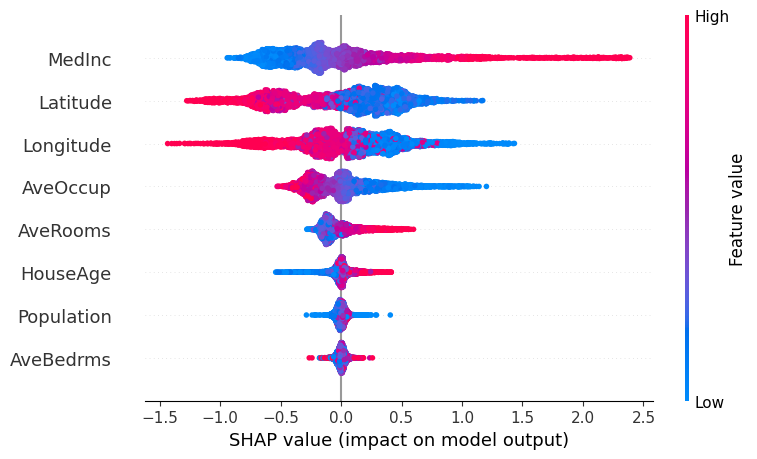

In [27]:
# tree
shap.summary_plot(shap_values_tree, df_test[explainer_sswarm.used_feats])

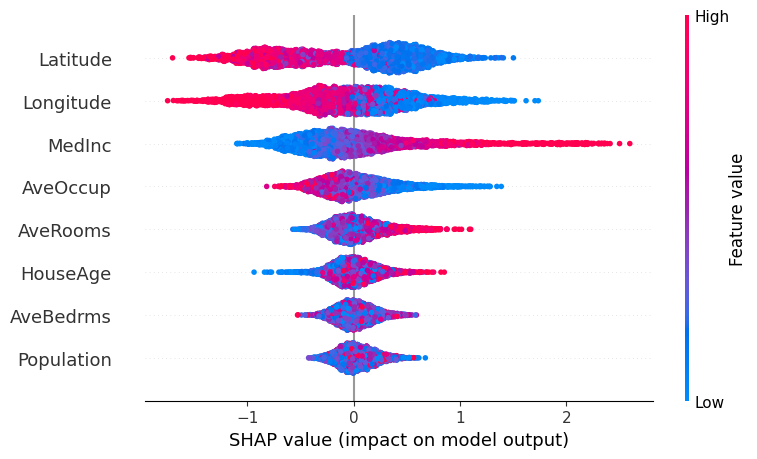

In [28]:
# 1 repeat
shap.summary_plot(shap_values_sswarm_1, df_test[explainer_sswarm.used_feats])

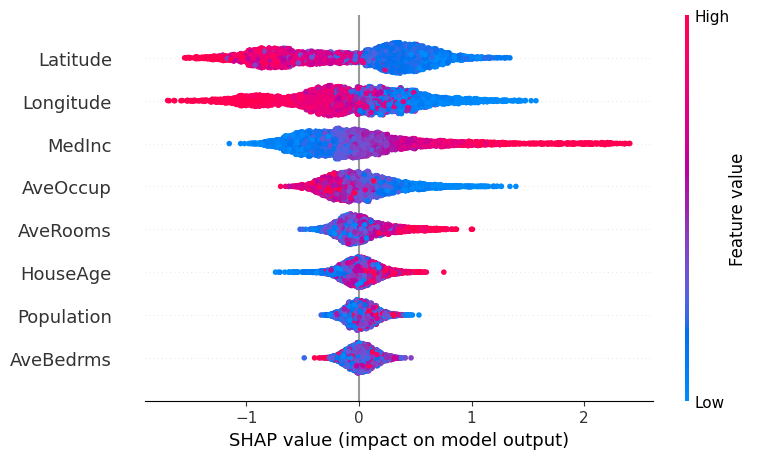

In [29]:
# 2 repeat
shap.summary_plot(shap_values_sswarm_2, df_test[explainer_sswarm.used_feats])

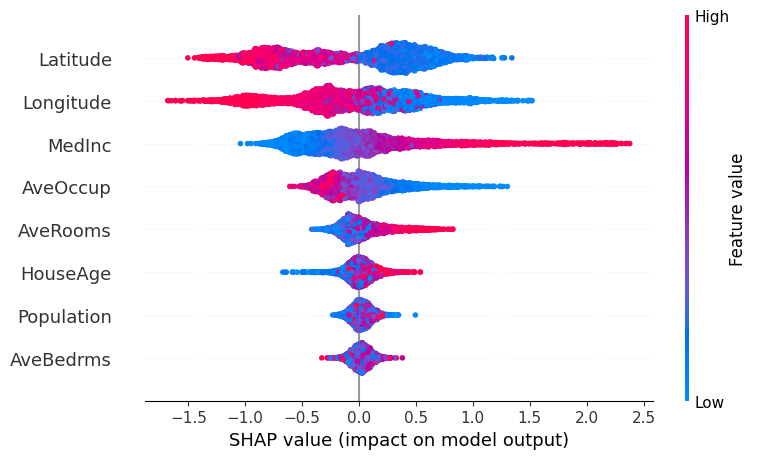

In [30]:
# 5repeat
shap.summary_plot(shap_values_sswarm_5, df_test[explainer_sswarm.used_feats])

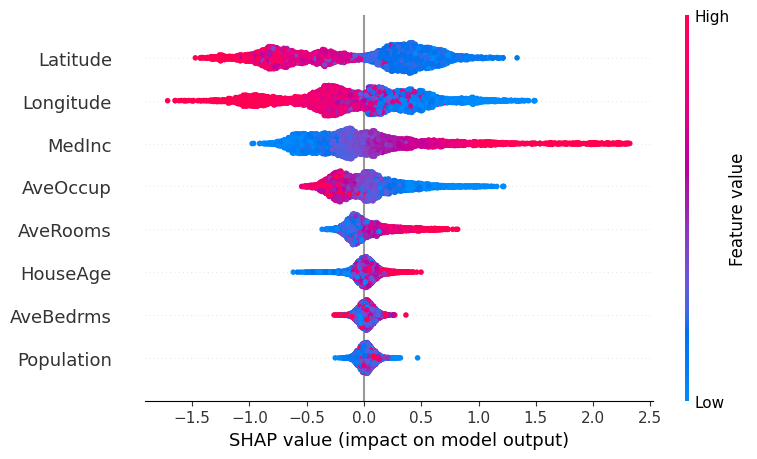

In [31]:
# 10 repeats
shap.summary_plot(shap_values_sswarm_10, df_test[explainer_sswarm.used_feats])

In [5]:
explainer_sswarm = SSWARM(automl, random_state=77)
shap_values_sswarm_1 = explainer_sswarm.shap_values(df_test, n_repeats=1)

explainer_sswarm = SSWARM(automl, random_state=77)
shap_values_sswarm_5 = explainer_sswarm.shap_values(df_test, n_repeats=5)

explainer_sswarm = SSWARM(automl, random_state=77)
shap_values_sswarm_10 = explainer_sswarm.shap_values(df_test, n_repeats=10)

 12%|██████████▉                                                                                  | 118/1000 [00:02<00:33, 26.63it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
POINT
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


 38%|███████████████████████████████████▎                                                         | 380/1000 [00:06<00:10, 60.38it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


 42%|██████████████████████████████████████▊                                                      | 417/1000 [00:06<00:08, 69.36it/s]
KeyboardInterrupt



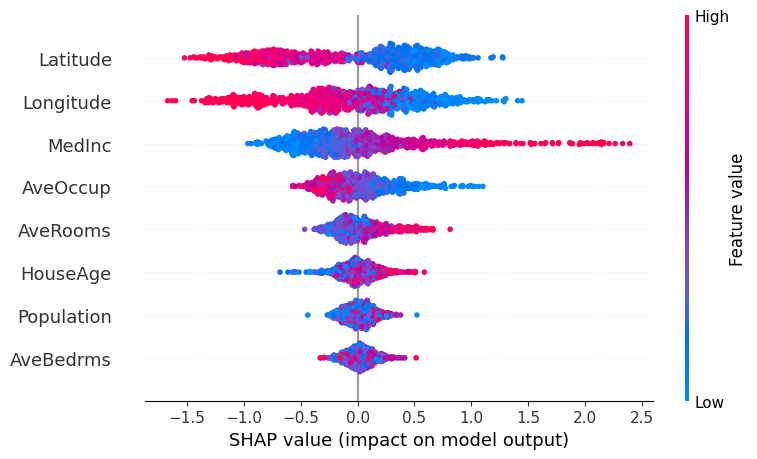

In [22]:
# 1 repeat
shap.summary_plot(shap_values_sswarm_2, df_test[explainer_sswarm.used_feats])

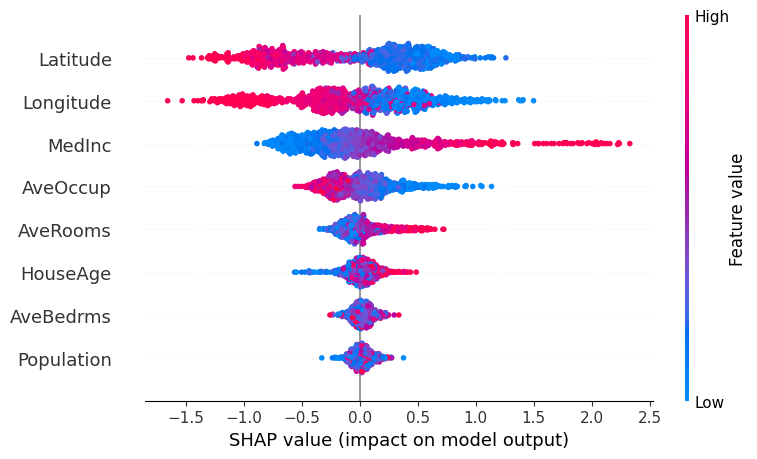

In [23]:
# 5 repeats
shap.summary_plot(shap_values_sswarm_5, df_test[explainer_sswarm.used_feats])

 49%|███████████████████▋                    | 984/2000 [07:12<07:27,  2.27it/s]


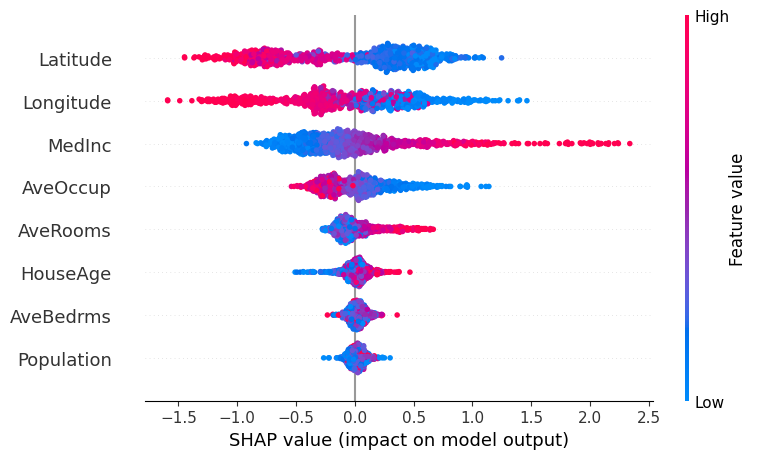

In [24]:
# 10 repeats
shap.summary_plot(shap_values_sswarm_10, df_test[explainer_sswarm.used_feats])